<font size="8">**Final Report**

<font size="8">**Introduction**

### What is Diabetes?

Diabetes is a metabolic condition where the body is unable to regulate blood sugar levels effectively (American Diabetes Association, 2013). It is a common disease, with 38.5% of men and 32.8% of women in the US at risk of the condition as reported in the year 2000 (Gray et al., 2015). There exists 2 types of diabetes: Type I and Type II. Type I diabetes affects around 5-10% of those with diabetes and is when the body doesn’t *produce* insulin (a blood sugar regulating hormone) and is therefore unable to regulate blood sugar levels. Type II diabetes is when the body either doesn’t produce *enough* insulin or doesn’t use it effectively and this type accounts for around 90-95% of those diagnosed with diabetes (American Diabetes Association, 2013).

### Diagnosing Diabetes & Question

The standard for diabetes diagnosis is dictated by ones' blood test results that show Hemoglobin A1c (a component of blood) levels ≥ 6.5 (American Diabetes Association (2013), Patel et al., 2023). Higher blood Glucose levels are also typically shown to be associated with diabetes (American Diabetes Association (2013), Patel et al., 2023). Interestingly, a study conducted on factors associated with diabetes strongly suggest that Body Mass Index (BMI) is associated with diabetes. The results suggested that those with even moderately higher BMI's are associated with an increased risk of developing diabetes (Gray et al., 2015., Patel et al., 2023). Thus, for this project, we aim to answer the question: **Can we predict a patient's diabetes diagnosis based on their blood glucose level (mg/dL) and BMI (kg/m2)?**
    
### Dataset

The dataset we will be using for this project contains demographic and laboratory variables on African-American patients including height, weight, gender, age, Hemoglobin A1c level, blood pressure etc. The dataset was initially compiled by Mohamadreza Momeni to use for machine learning models in diabetes diagnosis.

### Biases in diabetes literature review

The motivation for using this dataset is to encourage equity in medical research by using data from a racially diverse sample. A 2023 study on the diagnosis of diabetes has found that current literature on the diagnosis of diabetes is biased as a large number of diabetes diagnosis models are based on data collected largely from non-hispanic Whites. This implicates a dangerous overdiagnosis of diabetes among non-hispanic Whites *and* an underdiagnosis of diabetes among non-hispanic Blacks (Cronjé et al., 2023). Thus, we have chosen to conduct our project using this dataset as it consists of African-American participants with the aim of avoiding biases in diagnostic models and equity in healthcare by contributing diverse data within the diabetes literature. 
    
### References

<font size="2">American Diabetes Association. (2013). Diagnosis and Classification of Diabetes Mellitus. *Diabetes Care, 37(1)*, S81–S90. https://doi.org/10.2337/dc14-S081

<font size="2">Cronjé, Héléne T., Katsiferis, Aleandros, Elsenburg, Leonie K., Andersen, Theo O., Rod, Naja H. Varga, Tibor V. (2023). Assessing racial bias in type 2 diabetes risk prediction algorithms. *PLOS Glob Public Health. 2023; 3(5)*, e0001556. https://doi.org/10.1371/journal.pgph.0001556

<font size="2">Gray, Natallia., Picone, Gabriel., Sloan, Frank., Yashkin, Arseniy. (2015). The Relationship between BMI and Onset of Diabetes Mellitus and its Complications. *National Library of Medicine, 108(1), 29-36*. https://doi: 10.14423/SMJ.0000000000000214

<font size="2">Momeni, Mohamadreza. (2023). Diabetes. Version 1 . Retrieved Oct 24, 2023 from https://www.kaggle.com/datasets/imtkaggleteam/diabetes 

<font size="2">Patel, B. J., Mehta, D. N., Vaghani, A., & Patel, K. (2023). Correlation of Body Mass Index (BMI) with Saliva and Blood Glucose Levels in Diabetic and Non-Diabetic Patients. *Journal of pharmacy & bioallied sciences, 15(Suppl 2)*, S1204–S1207. https://doi.org/10.4103/jpbs.jpbs_159_23


<font size="8">**Methods**
    
-- Description of methods -- write this after we've done all the code --

Please run the following cell to load the library packages necessary
    
### References
    
Fehring, Thomas, K., Odum, Susan, M., Griffin, William, L., Mason, Bohannon., McCoy, Thomas H. (2007). The Obesity Epidemic: Its Effect on Total Joint Arthroplasty. *The Journal of Arthroplasty, 22(6)*, 71-76. https://doi.org/10.1016/j.arth.2007.04.014


In [4]:
# Run this cell before continuing
library(rvest)
library(tidyverse)
library(tidymodels)
library(repr)
install.packages("themis")
library(themis)
install.packages('kknn')
library(kknn)
source('tests.R')
source('cleanup.R')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


## **1) Load Data**

Our data is loaded from the URL generated through GitHub

In [5]:
URL <- 'https://raw.githubusercontent.com/wmma2/group_18_project/main/diabetes.csv'
diabetes_data <- read_csv(URL)

head(diabetes_data, 3)
tail(diabetes_data, 3)

Rows: 403 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): location, gender, frame
dbl (16): id, chol, stab.glu, hdl, ratio, glyhb, age, height, weight, bp.1s,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000,203,82,56,3.6,4.31,Buckingham,46,female,62,121,medium,118,59,NA,NA,29,38,720
1001,165,97,24,6.9,4.44,Buckingham,29,female,64,218,large,112,68,NA,NA,46,48,360
1002,228,92,37,6.2,4.64,Buckingham,58,female,61,256,large,190,92,185,92,49,57,180


id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41510,194,269,38,5.1,13.63,Louisa,29,female,69,167,small,120,70,NA,NA,33,40,20
41752,199,76,52,3.8,4.49,Louisa,41,female,63,197,medium,120,78,NA,NA,41,48,255
41756,159,88,79,2.0,NA,Louisa,68,female,64,220,medium,100,72,NA,NA,49,58,900


## **2) Clean & Wrangle Data**

The dataset is already tidy. 

To make it suitable for our analysis, we will need to create 2 new columns: **diagnosis** (our categorical column) and **BMI** (in *kg/m^2*) (one of our predictor variables). 

- The **diagnosis** column will use data from the `glyhb` (Glycosylated Hemoglobin) column which corresponds to Hemoglobin A1c levels to indicate whether a person has diabetes or not. Rows that are greater or equal to 6.5 will be 'yes' and rows that are less than 6.5 will be 'no'.

- The **BMI** column will use data from the `weight` and `height` columns. BMI will be calculated using the standard formula (Fehring, 2007): BMI = (`weight` $\times$ 0.45359237) / (`height` $\times$ 0.0254)

Additionally, we filter out the rows with missing values as they are not significant to our dataset.

Finally, we will select the necessary columns: `stab.glu`, `BMI` and `diagnosis` as we are interested in the whether the factors `stab.glu` (Blood glucose levels) and `BMI` are related to the diabetes diagnosis.

Our clean and wrangled data will be assigned to a new tibble called `tidy_diabetes`.

In [6]:
tidy_diabetes <- diabetes_data |>

#Create 'diagnosis' column
        mutate(diagnosis = if_else(glyhb >= 6.5, "yes", "no")) |>
        mutate(diagnosis = as_factor(diagnosis))|>

#Create 'BMI' column
        mutate(height_m = height*0.0254, 
               weight_kg = weight*0.45359237,
               BMI = weight_kg/height_m^2) |>

#Filter missing values
        filter(!is.na(glyhb + BMI + stab.glu)) |>

#Select necessary columns
        select(stab.glu, BMI, diagnosis)
               
head(tidy_diabetes)

stab.glu,BMI,diagnosis
<dbl>,<dbl>,<fct>
82,22.13096,no
97,37.41923,no
92,48.37028,no
93,18.63784,no
90,27.82477,yes
94,26.49935,no


With the clean and wrangled data above, we can now continue with our data analysis.

## **3) Exploratory Data Analysis**

#### **3.1) Split data**

First we split the `tidy_diabetes` dataset into training (`diabetes_train`) and testing (`diabetes_test`) data so that we can continue exploratory data analysis with the training dataset. We have chosen to have 75/25 split with 75% training set and 25% in the testing set.

Finally, we count the number of missing values in our data to see if we need to remove any missing data.

In [7]:
# set.seed(4321) #Don't remove this

# diabetes_split <- initial_split(tidy_diabetes, prop = 0.75 , strata = diagnosis)
# diabetes_train <- training(diabetes_split)
# diabetes_test <- testing(diabetes_split)

#### **3.2) Uneven data proportion**

As we were looking at our data on Kaggle, it seemed that there was a lot more rows with those who don't have diabetes than those who do. To check for this we will use the `count` for the `diagnosis` column.

In [8]:
train_count <- tidy_diabetes|>
    group_by(diagnosis)|>
    summarize(count = n()) 

#### **3.3) Distributions of BMI & stab.glu**

Next, we calculate the means of the variables `BMI` and `stab.glu` to check if will need to standardize our data.

In [9]:
train_mean <- tidy_diabetes|>
    summarize(stab.glu_mean = mean(stab.glu),
              BMI_mean = mean(BMI))

#### **3.4) Count missing Data**

Finally, we count the number of missing values in our data to see if we need to remove any missing data.

In [11]:
train_NAs <- sum(is.na(tidy_diabetes))

### **Summary of exploratory data analysis**

In [12]:
#run this cell
train_count
train_mean
train_NAs

diagnosis,count
<fct>,<int>
no,321
yes,63


stab.glu_mean,BMI_mean
<dbl>,<dbl>
107.0859,28.78121


[1] 0

From `train_count`, we see that our data is uneven and needs to be upscaled when training our algorithm. 

From `train_mean`, we see that the means stab.glu and BMI vary by quite a bit, thus we will need to standardize the data.

We can also see that our dataset has no missing values, meaning we do not need to remove any values.

## **4) Visualization**

We will now plot blood glucose levels `stab.glu` and `BMI` to see if there seems to be a correlation between the 2. We will color code the data points as whether or not the person is diagnosed with diabetes or not to visualize the relation of `stab.glu` & `BMI` to diabetes.

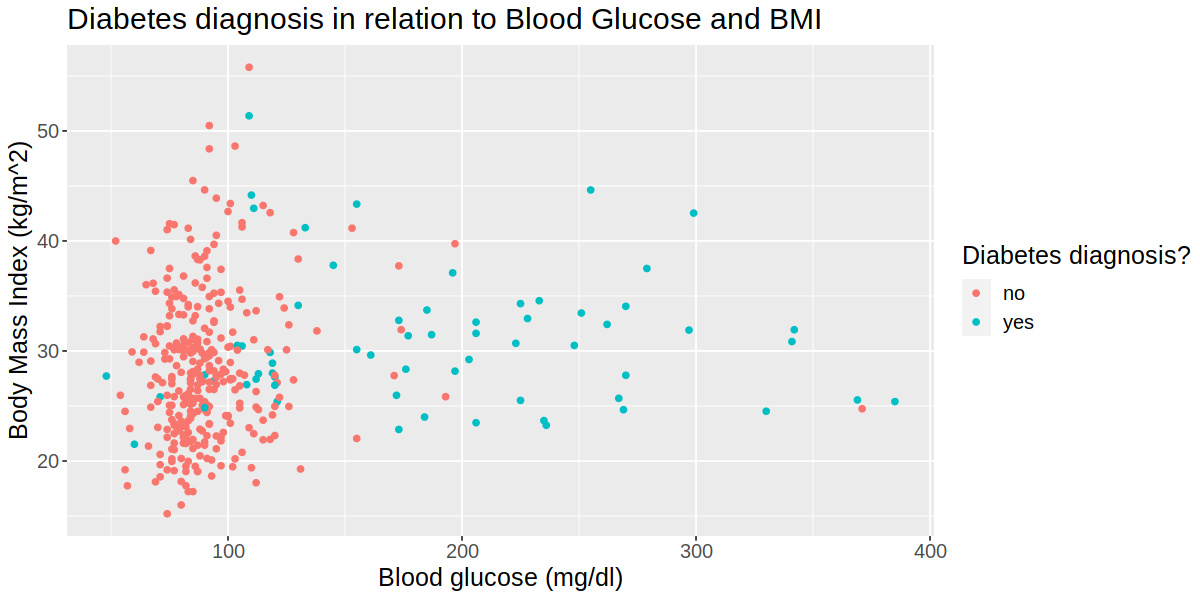

In [13]:
#run this cell
options(repr.plot.width = 10, repr.plot.height = 5)

train_plot <- tidy_diabetes |>
    ggplot(aes(x = stab.glu, y = BMI, colour = diagnosis)) +
    geom_point() +
    labs(x = "Blood glucose (mg/dl)", y = "Body Mass Index (kg/m^2)", colour = "Diabetes diagnosis?") +
    ggtitle('Diabetes diagnosis in relation to Blood Glucose and BMI') +
    theme(text=element_text(size = 15))

train_plot

From the plot above, we can see that a lower blood glucose level seems to be associated with no diabetes whereas the relation to BMI is hard to tell from this graph as the range of data in BMI of those with and without diabetes seem to be around the same.

From the visualization, we can also see that the range of blood glucose `stab.glu` is on a much larger scale than `BMI`, meaning it will have a greater effect on our k-NN model. To counter this, we will standardize the predictors in our data analysis.

## **5) Data Analysis**

Insert description...

#### **5.1) Upscaling uneven data**

In [50]:
set.seed(5432)

ups_recipe <- recipe(diagnosis~., data = tidy_diabetes) |>
    step_upsample(diagnosis, over_ratio = 1, skip = FALSE) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

##check

even_data <- bake(ups_recipe, tidy_diabetes)

even_count<- even_data |>
    group_by(diagnosis)|>
    summarize (count = n())

even_count

diagnosis,count
<fct>,<int>
no,321
yes,321


#### **5.2) Split data: training (75%), testing (25%)**

In [44]:
set.seed(1234)#Don't change this

diabetes_split <- initial_split(even_data, prop = 0.75, strata = diagnosis)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

head(diabetes_train)
head(diabetes_test)

stab.glu,BMI,diagnosis
<dbl>,<dbl>,<fct>
93,18.63784,no
92,28.20548,no
75,34.33549,no
89,35.78233,no
82,25.95949,no
128,40.75463,no


stab.glu,BMI,diagnosis
<dbl>,<dbl>,<fct>
82,22.13096,no
97,37.41923,no
92,48.37028,no
90,27.82477,yes
94,26.49935,no
87,24.51366,no


#### **5.2) Creating cross-validation sets**

In [45]:
#Separating into 5 diff sets
diabetes_vfold <- vfold_cv(diabetes_train, v = 5, strata = diagnosis)

head(diabetes_train)

# diabetes_recipe <- recipe(diagnosis ~ stab.glu + BMI,  data = even_data)



stab.glu,BMI,diagnosis
<dbl>,<dbl>,<fct>
93,18.63784,no
92,28.20548,no
75,34.33549,no
89,35.78233,no
82,25.95949,no
128,40.75463,no


#### **5.3) Tuning K**

In [46]:
#Tuning
set.seed(2023) # DO NOT REMOVE

knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('classification')
knn_tune


K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### **5.4) Recipe**

In [88]:

#scaled data 
diabetes_recipe <- recipe(diagnosis ~ stab.glu + BMI, data = diabetes_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

diabetes_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [90]:
knn_results <- workflow() |>
       add_recipe(diabetes_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = diabetes_vfold, grid = 10) |>
       collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8779189,5,0.018549371,Preprocessor1_Model1
2,roc_auc,binary,0.8599074,5,0.022245286,Preprocessor1_Model1
4,accuracy,binary,0.8952208,5,0.018631807,Preprocessor1_Model2
4,roc_auc,binary,0.8887037,5,0.025074921,Preprocessor1_Model2
5,accuracy,binary,0.9162734,5,0.015206791,Preprocessor1_Model3
5,roc_auc,binary,0.9168519,5,0.019225147,Preprocessor1_Model3
7,accuracy,binary,0.9197217,5,0.016388629,Preprocessor1_Model4
7,roc_auc,binary,0.9204630,5,0.021232619,Preprocessor1_Model4
8,accuracy,binary,0.9197217,5,0.016388629,Preprocessor1_Model5


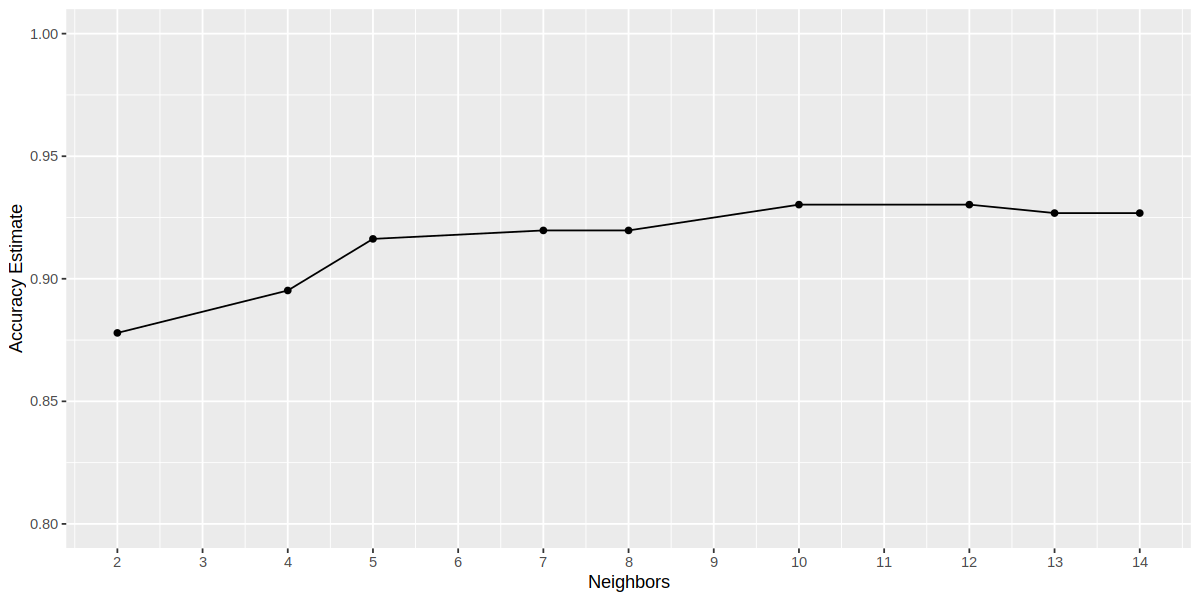

In [91]:
#Filter for accuracies
accuracies <- knn_results |> 
      filter(.metric == 'accuracy')

#plot best K
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.8, 1.0)) # adjusting the y-axis
accuracy_versus_k


In [95]:
set.seed(2023)
#set k
knn_spec_optimal <- nearest_neighbor(weight_func = 'rectangular', neighbors = 10) |>
    set_engine('kknn') |>
    set_mode('classification')
knn_spec_optimal

#results
knn_results_optimal <- workflow() |>
       add_recipe(diabetes_recipe) |>
       add_model(knn_spec_optimal) |>
       tune_grid(resamples = diabetes_vfold, grid = 10) |>
       collect_metrics()
knn_results_optimal

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 10
  weight_func = rectangular

Computational engine: kknn 


Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.9302480,5,0.007951034,Preprocessor1_Model1
roc_auc,binary,0.9309491,5,0.020876486,Preprocessor1_Model1


#### **5.4) Create K-NN classifier and train the classifier, k=3**

In [97]:
#Creating k-NN classifier
# knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 9) |>
#     set_engine('kknn') |>
#     set_mode('classification')

#Training the classifier
diabetes_workflow <- workflow() |>
    add_recipe(diabetes_recipe) |>
    add_model(knn_spec_optimal) |>
    fit(data = diabetes_train)

diabetes_workflow

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.06968641
Best kernel: rectangular
Best k: 10

#### **5.5) Fit Data**

In [98]:
diabetes_fit <- knn_spec_optimal |>
    fit(diagnosis ~ BMI+stab.glu, data = diabetes_train)
    
diabetes_fit

parsnip model object


Call:
kknn::train.kknn(formula = diagnosis ~ BMI + stab.glu, data = data,     ks = min_rows(10, data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.06968641
Best kernel: rectangular
Best k: 10

In [100]:
#predictions

diabetes_test_predictions <- predict(diabetes_fit, diabetes_test) |>
        bind_cols(diabetes_test)

head(diabetes_test_predictions)
tail(diabetes_test_predictions)

.pred_class,stab.glu,BMI,diagnosis
<fct>,<dbl>,<dbl>,<fct>
no,82,22.13096,no
no,97,37.41923,no
no,92,48.37028,no
no,90,27.82477,yes
no,94,26.49935,no
no,87,24.51366,no


.pred_class,stab.glu,BMI,diagnosis
<fct>,<dbl>,<dbl>,<fct>
no,81,34.76976,no
yes,270,34.05873,yes
no,126,32.37339,no
no,85,24.29542,no
no,85,21.95075,no
no,90,21.72884,no


In [101]:
diabetes_metrics <- diabetes_test_predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == 'accuracy')
diabetes_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8762887


In [102]:
#matrix
diabetes_mat <- diabetes_test_predictions |>
    conf_mat(truth = diagnosis, estimate = .pred_class)
diabetes_mat

          Truth
Prediction no yes
       no  79  10
       yes  2   6

## **Discussion**

summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?